In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import time
%matplotlib inline

### Load the data
-------

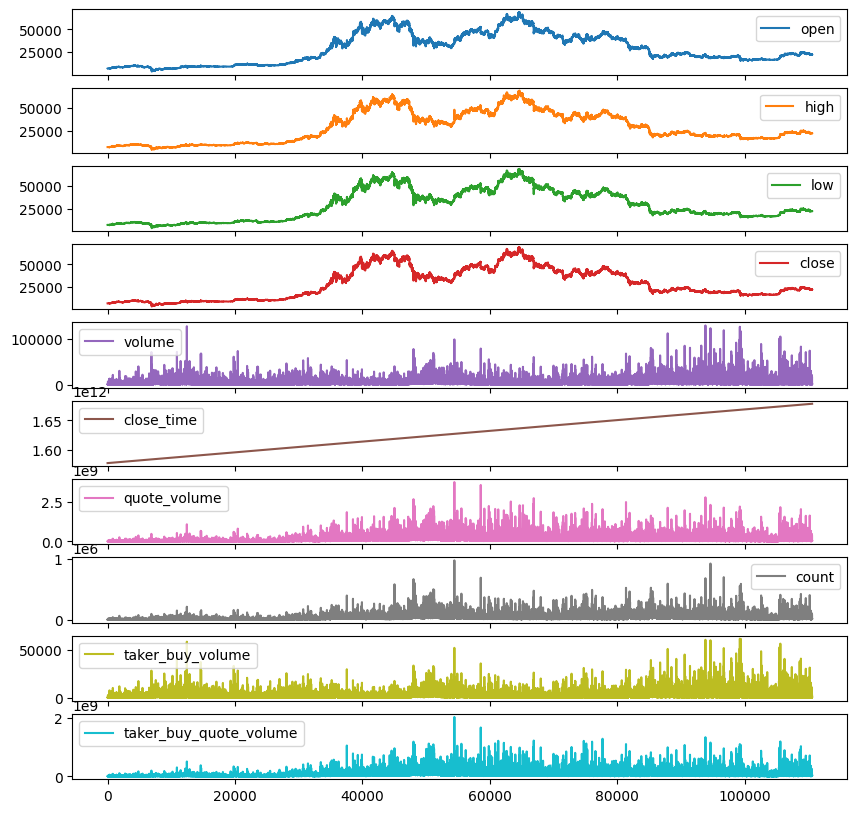

In [3]:
details = json.loads(open("details.json", "r").read())
X_data_path = details['coin'] + "_" + details['prediction'] + "_data.csv"
Y_data_path = details['coin'] + "_" + details['prediction'] + "_data.csv"

X_data_df = pd.read_csv(X_data_path)
Y_data_raw = pd.read_csv(Y_data_path)
#get only columns: open,	high,	low,	close
X_data_df = X_data_df.iloc[:,2:12]
Y_data_raw = Y_data_raw.iloc[:,2:12]

#show data with each column is a different color
X_data_df.plot(subplots=True, figsize=(10,10))
#to numpy 
X_data_raw = X_data_df.to_numpy()
Y_data_raw = Y_data_raw.to_numpy()

### Calculate the true labels
---------

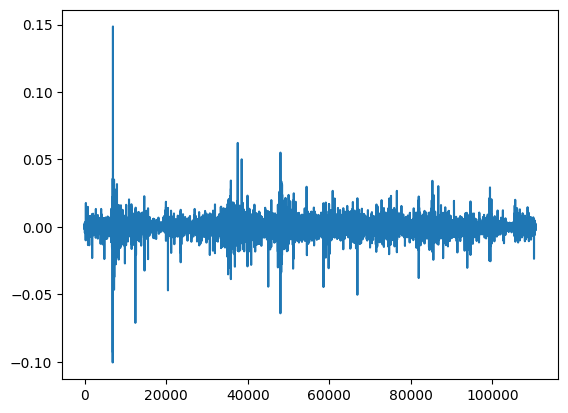

In [4]:
labels = details['label']

#open + close / 2
Y_data = (Y_data_raw[:,0] + Y_data_raw[:,3]) / 2

# Y_data[i] - Y_data[i-1]
Y_data_diff = np.diff(Y_data)

#calculate the percentage change
Y_data = Y_data_diff / Y_data[1:]

#show the data
plt.plot(Y_data)
plt.show()


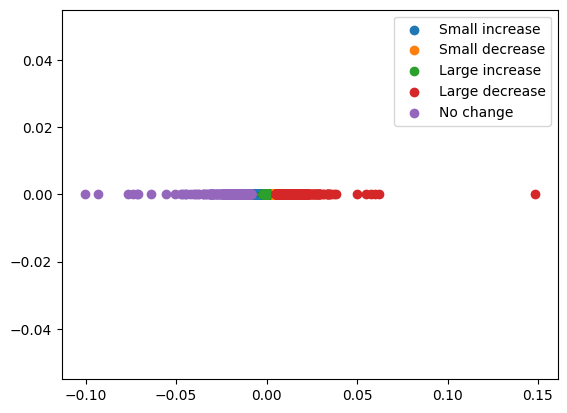

In [5]:
#Using k-means to cluster the data into 5 groups, scatter plot
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(Y_data.reshape(-1,1))
for i in range(5):
    plt.scatter(Y_data[kmeans.labels_==i], np.zeros(Y_data[kmeans.labels_==i].shape), label=labels[i])
plt.legend()
plt.show()

Y = kmeans.labels_

### Calculate the features
---------

__Features:__

- Open price
- Close price
- High price
- Low price
- Trading volume
- Moving averages (such as 10-day, 20-day, or 50-day)
- Relative strength index (RSI)
- Bollinger Bands
- MACD (Moving Average Convergence Divergence)
- On-balance volume (OBV)
- Average true range (ATR)
- Fibonacci retracement levels


In [6]:



PERIOD = 96*5
#Open + High + Low + Close + Volume
X = np.zeros((X_data_raw.shape[0] - PERIOD, 19))
#First 5
X[:,0:5] = X_data_raw[PERIOD:,0:5]

#normalize Volume
X[:,4] = X_data_raw[PERIOD:,4] / X_data_raw[PERIOD:,4].max()

#SMA in span of 1 day. (96 point of data)
sma = X_data_df.iloc[:,3].rolling(window=PERIOD).mean()[PERIOD:]
X[:,5] = sma

#EMA in span of 1 day. (96 point of data)
#EMA on high
ema = X_data_df.iloc[:,1].ewm(span=PERIOD).mean()[PERIOD:]
X[:,6] = ema

#RSI in span of 1 day. (96 point of data)
delta = X_data_df.iloc[:,3].diff()
A = delta.rolling(PERIOD).mean()

# Calculate average gain and average loss
AG = np.where(delta > 0, abs(A), 0 )
AL =  np.where(delta < 0, abs(A), 1 )

# Calculate RS and RSI
RS = AG / AL
RSI = 100 - (100 / (1 + RS))
X[:,7] = RSI[PERIOD:]

In [7]:
#Boilinger Bands
#Calculate the rolling mean and standard deviation
rolling_mean = X_data_df.iloc[:,3].rolling(window=PERIOD).mean()[PERIOD:]
rolling_std = X_data_df.iloc[:,3].rolling(window=PERIOD).std()[PERIOD:]

#Calculate the upper and lower Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)
X[:,8] = upper_band
X[:,9] = lower_band

#MACD
#Calculate the short term exponential moving average (EMA)
ShortEMA = X_data_df.iloc[:,3].ewm(span=12, adjust=False).mean()[PERIOD:]

#Calculate the long term exponential moving average (EMA)
LongEMA = X_data_df.iloc[:,3].ewm(span=26, adjust=False).mean()[PERIOD:]

#Calculate the MACD line
MACD = ShortEMA - LongEMA
X[:,10] = MACD

#OBV
#Calculate the On Balance Volume
OBV = np.zeros(X_data_raw.shape[0] - PERIOD)
OBV[0] = X_data_raw[PERIOD,4]
for i in range(1, X_data_raw.shape[0] - PERIOD):
    if X_data_raw[i + PERIOD,3] > X_data_raw[i + PERIOD - 1,3]:
        OBV[i] = OBV[i-1] + X_data_raw[i + PERIOD,4]
    elif X_data_raw[i + PERIOD,3] < X_data_raw[i + PERIOD - 1,3]:
        OBV[i] = OBV[i-1] - X_data_raw[i + PERIOD,4]
    else:
        OBV[i] = OBV[i-1]
X[:,11] = OBV

#normalize OBV
X[:,11] = X[:,11] / X[:,11].max()


#ADX
#Calculate the True Range
TR = np.zeros(X_data_raw.shape[0])
for i in range(1, X_data_raw.shape[0] ):
    TR[i] = max(X_data_raw[i ,1] - X_data_raw[i ,2], abs(X_data_raw[i ,1] - X_data_raw[i  - 1,3]), abs(X_data_raw[i ,2] - X_data_raw[i  - 1,3]))

#Calculate the Positive Directional Indicator and Negative Directional Indicator
PDI = np.zeros(X_data_raw.shape[0] )
NDI = np.zeros(X_data_raw.shape[0] )
for i in range(1, X_data_raw.shape[0] ):
    PDI[i] = 100 * (X_data_raw[i ,1] - X_data_raw[i  - 1,3]) / TR[i]
    NDI[i] = 100 * (X_data_raw[i  - 1,3] - X_data_raw[i ,2]) / TR[i]

#Calculate the Average Directional Movement Index
PDI = pd.DataFrame(PDI).ewm(span=14).mean()
NDI = pd.DataFrame(NDI).ewm(span=14).mean()
DX = 100 * abs(PDI - NDI) / (PDI + NDI)
ADX = pd.DataFrame(DX).ewm(span=14).mean()
X[:,12] = ADX[PERIOD:].to_numpy().reshape(X.shape[0])

#normalize ADX
X[:,12] = X[:,12] / X[:,12].max()

#ATR
#Use the above TR
ATR = pd.DataFrame(TR).ewm(span=14).mean()
X[:,13] = ATR[PERIOD:].to_numpy().reshape(X.shape[0])


C:\Users\Admin\AppData\Local\Temp\ipykernel_10692\168527050.py:50: RuntimeWarning: invalid value encountered in double_scalars
  PDI[i] = 100 * (X_data_raw[i ,1] - X_data_raw[i  - 1,3]) / TR[i]
C:\Users\Admin\AppData\Local\Temp\ipykernel_10692\168527050.py:51: RuntimeWarning: invalid value encountered in double_scalars
  NDI[i] = 100 * (X_data_raw[i  - 1,3] - X_data_raw[i ,2]) / TR[i]


In [8]:
#Fibonacci Retracement
#Calculate the Fibonacci Retracement
Fibonacci = np.zeros((X_data_raw.shape[0] - PERIOD, 5))
Fibonacci[:,0] = X_data_raw[PERIOD:,3] - X_data_raw[PERIOD:,2]
Fibonacci[:,1] = X_data_raw[PERIOD:,1] - X_data_raw[PERIOD:,3]
Fibonacci[:,2] = X_data_raw[PERIOD:,1] - X_data_raw[PERIOD:,2]
Fibonacci[:,3] = X_data_raw[PERIOD:,3] - X_data_raw[PERIOD:,0]
Fibonacci[:,4] = X_data_raw[PERIOD:,1] - X_data_raw[PERIOD:,0]

#normalize Fibonacci
Fibonacci = Fibonacci / Fibonacci.max()

X[:,14:19] = Fibonacci


### Train the model
---------

In [9]:
#Allign X[i-1] to Y[i]
X = X[1:]
Y = Y[PERIOD:]

l = X.shape[0]
ratio = 0.3
#only use the first 80% of the data for training
X = X[1:int(l*ratio)]
Y = Y[1:int(l*ratio)]
#Validation set is the rest of the data
X_val = X[int(l*ratio):]
Y_val = Y[int(l*ratio):]


#Y = Y_
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [10]:
class KNearestNeighbor():
    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, distance_function, predict_function, k=1):
        dists  = distance_function(self.X_train, X)
        labels = predict_function(self.y_train, dists, k=k)
        return labels
    
    @staticmethod
    def evaluate(y_test_pred, y_test, isprint=True):
        num_test = len(y_test.flatten())
        num_correct = np.sum(y_test_pred.flatten() == y_test.flatten())
        accuracy = float(num_correct) / num_test
        if isprint: print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        return accuracy

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [11]:
num_test = X_test.shape[0]

#To calculate the distance between two vectors, we can use the euclidean distance formula
def compute_distances_no_loop(X_train, X_test):
    result_mtx = np.sqrt(np.sum(X_test**2, axis=1, keepdims=True) + np.sum(X_train**2, axis=1) - 2 * X_test.dot(X_train.T))
    
    return result_mtx

def visualize_distance(dists):
    plt.imshow(dists, interpolation='none')
    plt.colorbar()
    plt.show()
# Test your implementation
dists_no = compute_distances_no_loop(X_train, X_test)
print("Train:", X_train.shape, "Test:",X_test.shape, "Result:",dists_no.shape)
visualize_distance(dists_no)
#y_test_pred = predict_labels(y_train, dists_no, k=1)
#classifier.evaluate(y_test_pred, y_test)

In [11]:
def predict_labels(y_train, dist, k=1):
    result_mtx = np.argsort(dist, axis=1)[:, :k]
    result = np.zeros(result_mtx.shape[0])
    for i in range(num_test):
        result[i] = np.argmax(np.bincount(y_train[result_mtx[i]].flatten()))
    return result
y_pred = predict_labels(y_train, dists_no * 1000, k=1)
classifier.evaluate(y_pred, y_test)

Got 2629 / 6087 correct => accuracy: 0.431904


0.4319040578281584